Import

In [16]:
import pandas as pd
import numpy as np
import optuna
import catboost as cb
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns

from fitting import  get_objective_Catboost, fit_CatBoost,generate_predictions

In [17]:
def import_data(file):
    """create a dataframe from a csv file"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    return df

df_train = import_data("input/train.csv")

In [18]:
X_train, y_train = (df_train.drop(columns=['score']), np.log1p(df_train['score']))

In [19]:
np.log1p(X_train).head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,AU26_r,AU45_r,bvpMean,bvpSD,edaMean,edaSD,hrMean,hrSD,tempMean,tempSD
0,16.551113,16.379463,18.522795,16.710302,16.155434,19.164467,18.626273,17.768167,20.578888,21.260396,...,0.147991,0.662297,2.043488,0.654164,0.053559,3.995158,4.452738,1.836083,3.524323,0.282671
1,21.601793,20.199904,23.848698,18.937539,18.788829,20.409781,17.928713,17.542580,19.266683,18.584019,...,0.507969,0.506982,0.885473,0.656032,-0.005758,4.473921,4.379623,2.239121,3.319231,0.162452
2,17.548259,16.919587,19.257419,17.763963,17.466005,19.264032,17.113705,17.104739,19.519586,17.663269,...,0.151575,0.650720,0.454357,0.092456,-0.001501,4.641919,4.359917,2.649786,3.326952,0.393783
3,20.018158,18.496177,22.266689,19.980138,18.432586,22.305255,19.962356,18.851866,22.154558,19.878350,...,0.763072,0.319383,0.043016,0.018092,-0.004689,3.143334,4.235234,1.560942,3.432065,0.808002
4,19.451612,18.799031,21.453211,19.862850,18.597930,22.417778,20.144501,18.972564,21.972877,19.748816,...,0.234127,0.125982,0.398823,0.102748,0.009120,4.448666,4.339940,2.259447,3.385434,0.199727


In [20]:
#plt.figure(figsize=(30,20))
#heatmap = sns.heatmap(X_train.iloc[:,:51].corr(), annot=True, fmt=".2f", cmap="coolwarm")

Modelling

In [21]:
#10 params
params5 = {'iterations': 519,
 'early_stopping_rounds': 35,
 'learning_rate': 0.01657134009652413,
 'depth': 9,
 'l2_leaf_reg': 73,
 'random_strength': 0.512749665058699,
 'rsm': 0.5908249568557574,
 'grow_policy': 'SymmetricTree',
 'sampling_frequency': 'PerTreeLevel',
 'min_data_in_leaf': 20,
 'border_count': 128,
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.4917186664343204}

#20 trials
params2={'iterations': 355,
 'early_stopping_rounds': 40,
 'learning_rate': 0.07239650141923706,
 'depth': 6,
 'l2_leaf_reg': 53,
 'random_strength': 0.7723882991451012,
 'rsm': 0.24081826914288895,
 'grow_policy': 'Lossguide',
 'max_leaves': 23,
 'min_data_in_leaf': 17,
 'border_count': 150,
 'bootstrap_type': 'MVS',
 'subsample': 0.3485372090100121}

#40 trials 0,19
params3 = {'iterations': 428,
 'early_stopping_rounds': 47,
 'learning_rate': 0.01967367348476125,
 'depth': 6,
 'l2_leaf_reg': 100,
 'random_strength': 1.9830818873975762,
 'rsm': 0.14464687534870552,
 'grow_policy': 'Lossguide',
 'max_leaves': 58,
 'min_data_in_leaf': 11,
 'border_count': 254,
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.955272189941001}

#40 trials number two
params4 ={'iterations': 577,
 'early_stopping_rounds': 37,
 'learning_rate': 0.01697831322499577,
 'depth': 10,
 'l2_leaf_reg': 47,
 'random_strength': 1.9485047797525747,
 'rsm': 0.40625407915018286,
 'grow_policy': 'Lossguide',
 'max_leaves': 25,
 'min_data_in_leaf': 15,
 'border_count': 14,
 'bootstrap_type': 'MVS',
 'subsample': 0.7503094668001254}

#40 trials number three, best one so far 0,156
params = {'iterations': 368,
 'early_stopping_rounds': 28,
 'learning_rate': 0.028890733332717765,
 'depth': 4,
 'l2_leaf_reg': 17,
 'random_strength': 1.3995804501442395,
 'rsm': 0.9969362511076745,
 'grow_policy': 'SymmetricTree',
 'sampling_frequency': 'PerTree',
 'min_data_in_leaf': 20,
 'border_count': 115,
 'bootstrap_type': 'MVS',
 'subsample': 0.6568685381601416}

#80 trials
params6 = {'iterations': 488,
 'early_stopping_rounds': 12,
 'learning_rate': 0.04180675819805017,
 'depth': 5,
 'l2_leaf_reg': 24,
 'random_strength': 0.7595284169363525,
 'rsm': 0.41345049183353516,
 'grow_policy': 'Depthwise',
 'sampling_frequency': 'PerTreeLevel',
 'min_data_in_leaf': 13,
 'border_count': 211,
 'bootstrap_type': 'MVS',
 'subsample': 0.8223817477837211}

In [8]:

#This is timeconsuming code, and has already been run
#The best parameters are already in the params variable
objective = get_objective_Catboost(X_train, y_train)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=80, n_jobs=-1) #, n_jobs=-1
trial = study.best_trial

[I 2023-10-25 21:29:05,995] A new study created in memory with name: no-name-1c4f7842-873d-46d0-9636-9412b3971356
[I 2023-10-25 21:29:22,246] Trial 4 finished with value: 2.3400275663310164 and parameters: {'iterations': 155, 'early_stopping_rounds': 8, 'learning_rate': 0.0032833162491513594, 'depth': 7, 'l2_leaf_reg': 5, 'random_strength': 0.4542853670267484, 'rsm': 0.7170397895873869, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTree', 'min_data_in_leaf': 17, 'border_count': 183, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3088570367121577}. Best is trial 4 with value: 2.3400275663310164.
[I 2023-10-25 21:29:50,729] Trial 0 finished with value: 0.11266243646389369 and parameters: {'iterations': 426, 'early_stopping_rounds': 30, 'learning_rate': 0.007680438306415739, 'depth': 4, 'l2_leaf_reg': 28, 'random_strength': 0.30174640107733397, 'rsm': 0.46473125217806044, 'grow_policy': 'Depthwise', 'sampling_frequency': 'PerTreeLevel', 'min_data_in_leaf': 20, 'border_count': 254, 

function

In [9]:
trial.params

{'iterations': 488,
 'early_stopping_rounds': 12,
 'learning_rate': 0.04180675819805017,
 'depth': 5,
 'l2_leaf_reg': 24,
 'random_strength': 0.7595284169363525,
 'rsm': 0.41345049183353516,
 'grow_policy': 'Depthwise',
 'sampling_frequency': 'PerTreeLevel',
 'min_data_in_leaf': 13,
 'border_count': 211,
 'bootstrap_type': 'MVS',
 'subsample': 0.8223817477837211}

In [10]:
params = trial.params

In [22]:
mod = fit_CatBoost(params,X_train, y_train)

In [23]:
mod.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MAE',
 'iterations': 368,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Exact',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 17,
 'random_strength': 1.399580478668213,
 'od_type': 'Iter',
 'rsm': 0.9969362616539,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.6568685173988342,
 'use_best_model': True,
 'od_wait': 28,
 'random_seed': 42,
 'depth': 4,
 'posterior_sampling': False,
 'border_count': 115,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 

In [24]:
test= import_data("input/test.csv")
testX = test.drop(columns=['score'])
testy =test['score']

In [25]:
predictions = generate_predictions(mod, testX)

In [26]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predictions, testy)
print(mse)

0.15624139390446895


Feature importance graphs

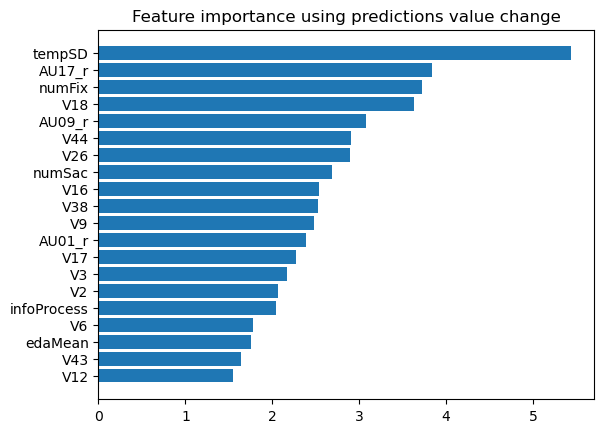

In [28]:
sorted_feature_importance = mod.feature_importances_.argsort()
top20features = sorted_feature_importance[-20:]
#plt.barh(X_train.columns[sorted_feature_importance], mod.feature_importances_[sorted_feature_importance])
plt.barh(X_train.columns[top20features], mod.feature_importances_[top20features])
plt.title("Feature importance using predictions value change")
plt.show()

Hjelpekode:

In [29]:
def log_loss(m, X, y): 
    return metrics.log_loss(y,m.predict_proba (X)[:,1])
    
def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

In [30]:
import shap

c:\Users\baryd\.conda\envs\TDT4173\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\baryd\.conda\envs\TDT4173\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

In [32]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(mod, testX, testy, log_loss)
    

    
    elif method == "ShapeValues":
        shap_values = mod.get_feature_importance(cb.Pool(testX, label=testy), type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, testX) 
        
    else:
        fi = mod.get_feature_importance(cb.Pool(testX, label=testy), type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(testX.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

# Prediciton Values Change
The individual importance values for each of the input features.
For each feature, PredictionValuesChange shows how much on average the the prediciton changes if the feature value changes. The bigger the value the value of the importance the bigger on average is the change to the prediction value, if this feature is changed. 

Specifics:
* Feature importance values are normalized so that the sum of importances of all features is equal to 100. This is possible because the values of these importances are always non-negative.

* Link to info: https://catboost.ai/en/docs/concepts/fstr


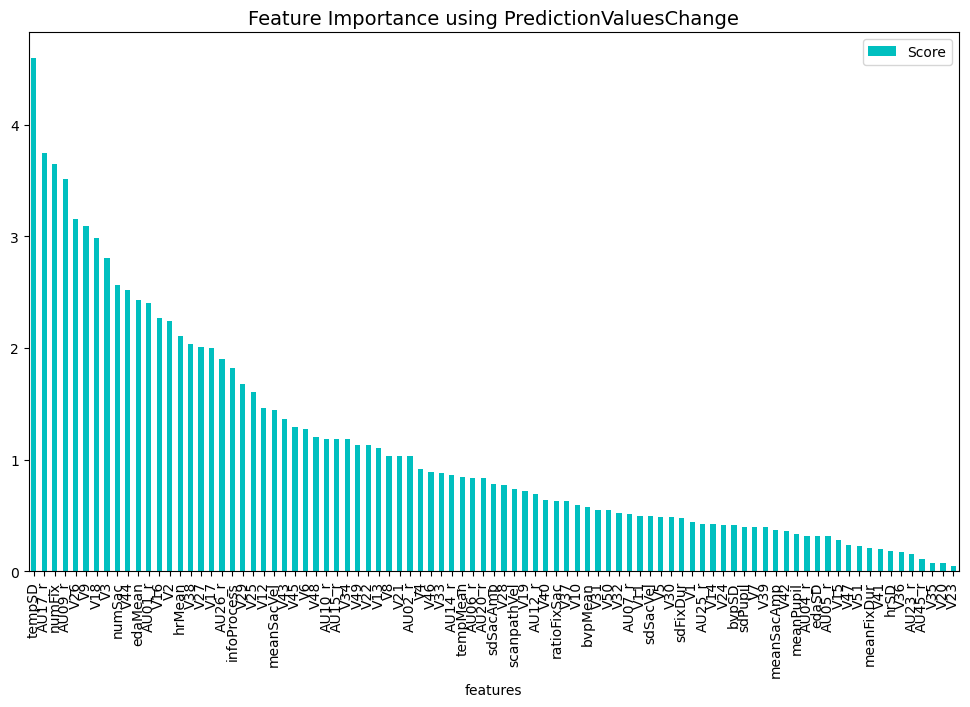

In [34]:
get_feature_imp_plot(method="PredictionValuesChange")

# LossFunctionChange

Used for ranking metrics, probably not important for us

For each feature the value represents the difference between the loss value of the model with this feature and without it. The model without this feature is equivalent to the one that would have been trained if this feature was excluded from the dataset.

Could be an idea to exclude all features with negative values, if I understand it correctly


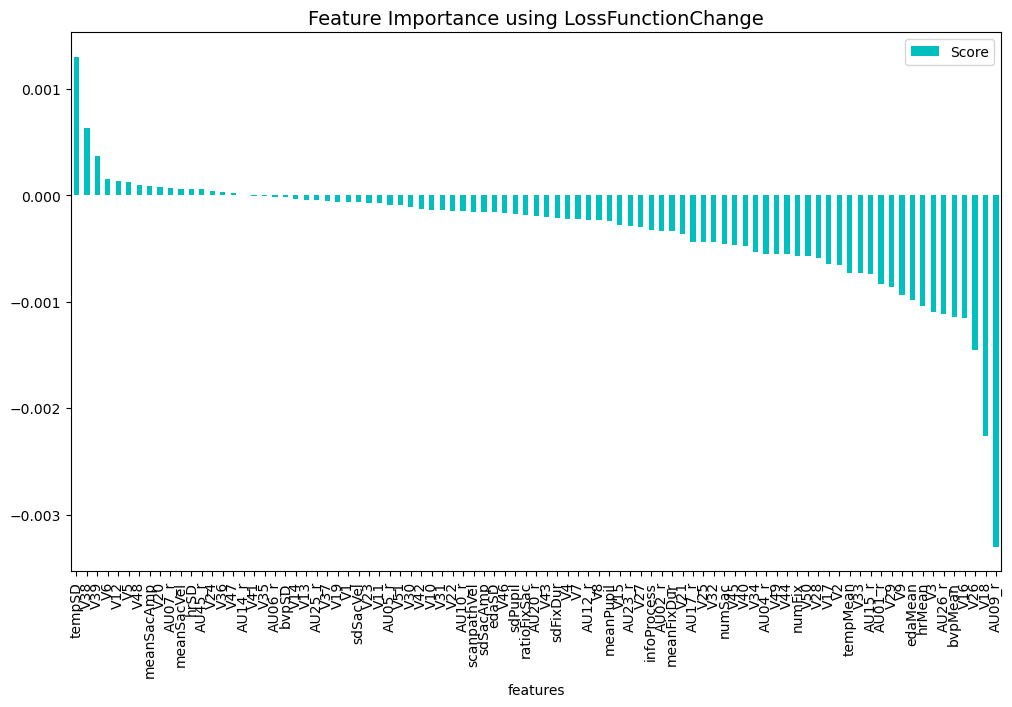

In [35]:
get_feature_imp_plot(method="LossFunctionChange")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


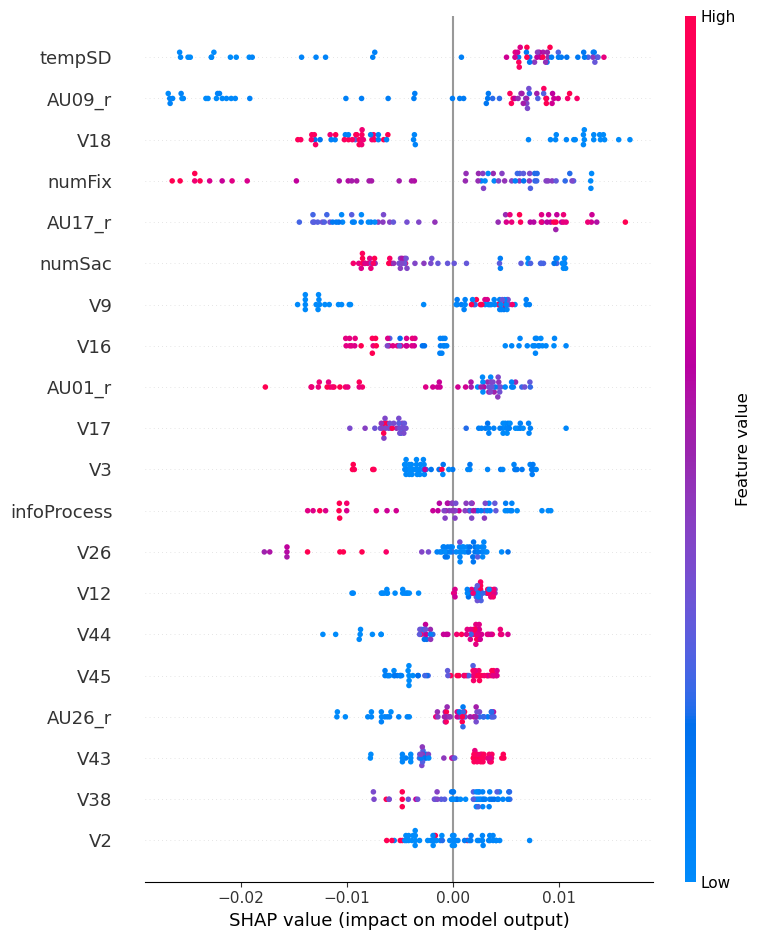

In [36]:
get_feature_imp_plot(method="ShapeValues")

Feature pair importance

In [37]:
fi = mod.get_feature_importance(cb.Pool(testX, label=testy), type="Interaction")

In [38]:
fi_new = []
for k, item in enumerate(fi):
    first = testX.dtypes.index[int(fi[k][0])]
    second = testX.dtypes.index[int(fi[k][1])]
    if first != second:
        fi_new.append([first + " | " + second, fi[k][2]])
    

In [39]:
fi_new[:5]

[['V26 | tempSD', 1.2765678711281911],
 ['V2 | V44', 0.5608507553875177],
 ['V26 | meanSacVel', 0.5602509881481015],
 ['V3 | AU02_r', 0.5309260653810872],
 ['V6 | V44', 0.4979638306430735]]

# Pairwise Feature Importance
Now V26 and tempSD seems very important now

https://catboost.ai/en/docs/concepts/feature-interaction#feature-interaction-strength

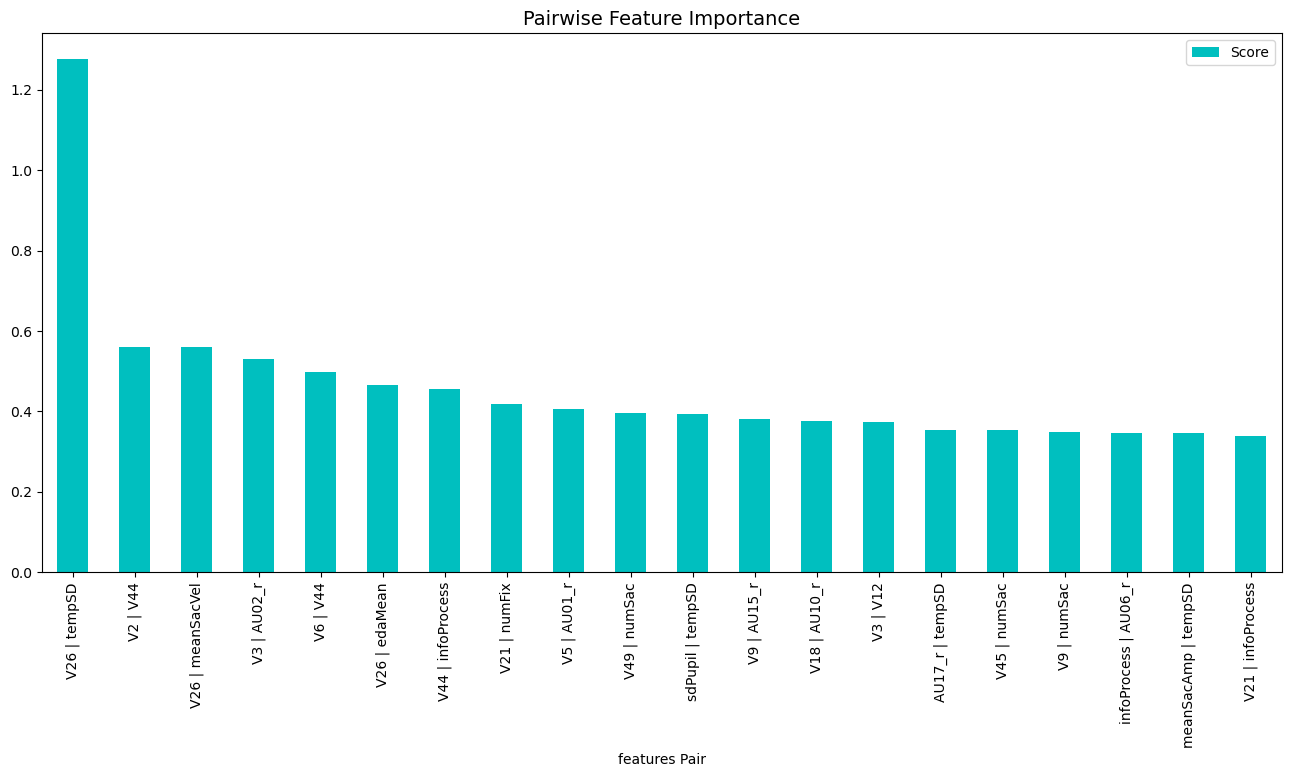

In [40]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[0:20]
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()

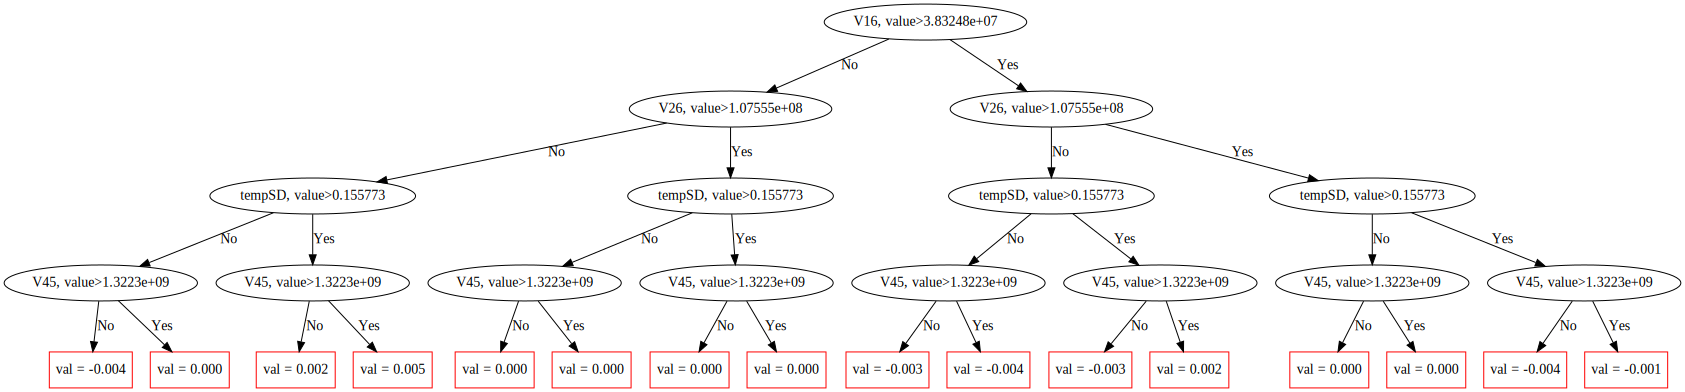

In [42]:
mod.plot_tree(tree_idx=2, pool=cb.Pool(testX, label=testy))